In [2]:
%reload_ext autoreload
%autoreload 2

import pickle
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

from utilities import load_data, arabic_normalizer, english_normalizer
from resources import (ShapeChecker, Encoder, Decoder, BahdanauAttention, 
                       MaskedLoss, TrainTranslator, BatchLogs, Translator,
                       load_model, load_preprocessor)

In [5]:
BATCH_SIZE = 64 # TODO: config
EMBEDDING_DIM = 256 # TODO: config
UNITS = 1024 # TODO: config
TRAIN_DATA_FILE = "Listpairs_Arabic_English.pkl" # TODO: config
TEST_DATA_FILE = "Listpairs_Arabic_English.pkl"

MAX_VOCAB_SIZE = 10000 # TODO: config

#### Training

In [50]:
targ, inp = load_data(TRAIN_DATA_FILE)
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(len(inp))
dataset = dataset.batch(BATCH_SIZE)

In [63]:
from typing import Union, List

class Pipeline():
    def __init__(self):
        self.trained_translator = None
    def train_preprocessors(self,
                            inp_data:List[str], 
                            targ_data: List[str], 
                            max_vocab_size: int,
                            inp_proc_save_name: Union[str, bool],
                            targ_proc_save_name: Union[str, bool]) -> None:
        
        
        self.max_vocab_size = max_vocab_size
        self.arabic_normalizer= arabic_normalizer
        self.english_normalizer= english_normalizer
        
        self.output_text_processor = tf.keras.layers.TextVectorization(
                                    standardize=self.arabic_normalizer,
                                    max_tokens=self.max_vocab_size)

        self.input_text_processor = tf.keras.layers.TextVectorization(
                                    standardize=self.english_normalizer,
                                    max_tokens=self.max_vocab_size)
        
        for data in [inp_data, targ_data]:
            assert isinstance(data, list) and all([isinstance(i, str) for i in data])
        if any([inp_proc_save_name, targ_proc_save_name]):
            assert all([inp_proc_save_name, targ_proc_save_name])
            
        self.input_text_processor.adapt(inp_data)
        self.output_text_processor.adapt(targ_data)
        
        if all([inp_proc_save_name, targ_proc_save_name]):
            for p, n in zip([self.input_text_processor, self.output_text_processor], 
                        [inp_proc_save_name, targ_proc_save_name]):
                pickle.dump({'config': p.get_config(),
                     'weights': p.get_weights()}
                    , open(n, "wb"))
        else:
            print("You must specify input and output preprocessor names that you wish to save to file.")

    def train_translator(self, 
                         units: int, 
                         embedding_dim: int, 
                         n_epochs: int,
                         save_file_name: str) -> TrainTranslator:
        
        translator = TrainTranslator(EMBEDDING_DIM, 
                                        UNITS,
                                        input_text_processor=self.input_text_processor,
                                        output_text_processor=self.output_text_processor,
                                        use_tf_function=True)

        translator.compile(
                            optimizer=tf.optimizers.Adam(),
                            loss=MaskedLoss())
        self.batch_loss = BatchLogs('batch_loss')
        self.dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(len(inp))
        self.dataset = self.dataset.batch(BATCH_SIZE)
        translator.fit(self.dataset, epochs=n_epochs,
                     callbacks=[batch_loss])
        self.translator.save_weights(save_file_name, save_format="tf")
        return self.translator
    
    def translate(self):
        load_model(input_processor,
                   output_processor,
                   weights,
        

In [64]:
pipeline = Pipeline()

In [65]:
pipeline.train_preprocessors(inp_data=inp,
                    targ_data=targ,
                    max_vocab_size=MAX_VOCAB_SIZE,
                    inp_proc_save_name="test_input_pro.pkl",
                    targ_proc_save_name="test_output_pro.pkl")

In [ ]:
pipeline.train_preprocessors()

In [12]:
attention_layer = BahdanauAttention(UNITS)
translator = TrainTranslator(
    EMBEDDING_DIM, UNITS,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=True)

loss = MaskedLoss()
optimizer = optimizer=tf.optimizers.Adam()

translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss())
batch_loss = BatchLogs('batch_loss')

In [13]:
SAVE_NAME = 'trained_translator_latest'
translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])
translator.save_weights(SAVE_NAME, save_format="tf")

Epoch 1/3
190/190 [==============================] - 183s 942ms/step - batch_loss: 5.4613
Epoch 2/3
190/190 [==============================] - 177s 930ms/step - batch_loss: 4.3459
Epoch 3/3
190/190 [==============================] - 178s 934ms/step - batch_loss: 3.4422


Text(0, 0.5, 'CE/token')

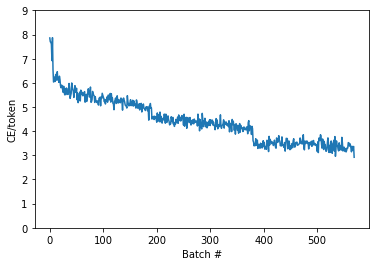

In [14]:
warnings.filterwarnings("ignore")
plt.plot(batch_loss.logs)
plt.ylim([0, 9])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

#### Testing

This refers to querying English sentences that we understand and judging the accuracy of translation of the target language (in this case, Arabic).

In [20]:
# load preprocessors and model structure
preprocessor = load_preprocessor(input_preprocessor="_input_processor.pkl", 
                                 output_preprocessor="_output_processor.pkl", 
                                 en_norm=english_normalizer, ar_norm=arabic_normalizer)
translator = load_model(input_processor=preprocessor[0], 
                        output_processor=preprocessor[1], 
                        weights = 'trained_translator_w',
                        embedding_dim=EMBEDDING_DIM,
                        units=UNITS)

In [70]:
query = ["Do you like coffee?", "test"]
query = [tf.constant([element]) for element in query]
result = translator.translate_unrolled(input_text = query)
[result['text'][i].numpy().decode() for i in range(len(query))]

['هل تحب القهوة كثيرا ؟', 'اغلق فمك']